# SVM判断振幅
利用SVM进行择时，目标是识别大趋势的到来

一、标注：<br>
- 判断未来一个月振幅是否大于5%，是则为1，不是则为0 <br>

二、特征：<br>
- 多周期乖离率
- 多周期波动率
- 多周期收益率

三、模型：<br>
- 2017/1/1到2021/1/1为训练集，2021/1/1到2023/1/1为测试集
- svc，由于特征非线形（？），选择rbf核

四、结果：<br>
- 样本外66%
- 个股的情况见末尾代码，可以随意替换观察效果，红点为正确信号，绿点为错误信号

参数读取

In [89]:
import yaml
with open('params.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)['params']
BEGIN_DATE = params['BEGIN_DATE']
END_DATE = params['END_DATE']
print('The begin date is: ', BEGIN_DATE)
print('The end date is: ', END_DATE)

The begin date is:  2017-01-01
The end date is:  2023-01-01


数据路径读取

In [124]:
from dotenv import load_dotenv
load_dotenv()
import os
PATH = os.getenv('DATA_PATH')

In [125]:
import pandas as pd
import numpy as np
import math
raw_data = pd.read_csv(PATH, parse_dates = True) # 读取中证1000股票数据
constituents = raw_data.stock.unique()[:200] # 只取前200个股票
raw_data = raw_data[(raw_data.date >= BEGIN_DATE) & (raw_data.stock.isin(constituents))]
raw_data.set_index(['date', 'stock'], inplace = True)
raw_data = raw_data[['close']]
# 未来10天跌5%则为正样本，否则为负样本
raw_data['label_short'] = abs(raw_data.close.shift(-21) / raw_data.close - 1) >= 0.05
raw_data = raw_data.dropna()
print(raw_data.head())

                          close  label_short
date       stock                            
2017-01-03 000582.SZ  11.259800         True
2017-01-04 000582.SZ  11.420455        False
2017-01-05 000582.SZ  11.357590         True
2017-01-06 000582.SZ  11.525230        False
2017-01-09 000582.SZ  11.553170        False


## 特征选取

### SMA
SMA有量纲，在截面上无意义，时序上意义也不大，污染特征库，因此不作为特征

In [91]:
# 添加三种均线特征
raw_data['ma5'] = raw_data.close.rolling(5).mean()
raw_data['ma10'] = raw_data.close.rolling(10).mean()
raw_data['ma20'] = raw_data.close.rolling(20).mean()
raw_data.tail(5)

,,close,label_short,ma5,ma10,ma20
date,stock,,,,,
2023-04-13,002519.SZ,5.24,False,5.262,5.340,5.3840
2023-04-14,002519.SZ,5.35,False,5.270,5.341,5.3935
2023-04-17,002519.SZ,5.34,False,5.298,5.326,5.3995
2023-04-18,002519.SZ,5.46,False,5.344,5.320,5.4055
2023-04-19,002519.SZ,5.44,False,5.366,5.322,5.4055


### BIAS
乖离率很好地描述了价格相对位置，作为特征
$$BIAS_N = \frac{Price - MA_N}{MA_N}$$

In [92]:
# 添加乖离率特征
raw_data['bias5'] = (raw_data.close / raw_data.ma5).apply(math.log)
raw_data['bias10'] = (raw_data.close / raw_data.ma10).apply(math.log)
raw_data['bias20'] = (raw_data.close / raw_data.ma20).apply(math.log)
raw_data.drop(['ma5', 'ma10', 'ma20'], axis = 1, inplace = True) # 省空间时间
raw_data.tail(5)

,,close,label_short,bias5,bias10,bias20
date,stock,,,,,
2023-04-13,002519.SZ,5.24,False,-0.004190,-0.018904,-0.027110
2023-04-14,002519.SZ,5.35,False,0.015066,0.001684,-0.008098
2023-04-17,002519.SZ,5.34,False,0.007896,0.002625,-0.011081
2023-04-18,002519.SZ,5.46,False,0.021474,0.025975,0.010032
2023-04-19,002519.SZ,5.44,False,0.013696,0.021930,0.006362


### VOLATILITY
波动率和乖离率一起比较配，很多指标都这么设计的
$$VOL_N=STD(Price_1,...,Price_N)$$

In [93]:
# 添加波动率特征
raw_data['vol5'] = raw_data.close.rolling(5).std()
raw_data['vol10'] = raw_data.close.rolling(10).std()
raw_data['vol20'] = raw_data.close.rolling(20).std()
raw_data.tail(5)

,,close,label_short,bias5,bias10,bias20,vol5,vol10,vol20
date,stock,,,,,,,,
2023-04-13,002519.SZ,5.24,False,-0.004190,-0.018904,-0.027110,0.055408,0.107703,0.132998
2023-04-14,002519.SZ,5.35,False,0.015066,0.001684,-0.008098,0.065955,0.107750,0.122529
2023-04-17,002519.SZ,5.34,False,0.007896,0.002625,-0.011081,0.058052,0.094304,0.116369
2023-04-18,002519.SZ,5.46,False,0.021474,0.025975,0.010032,0.078294,0.081650,0.116234
2023-04-19,002519.SZ,5.44,False,0.013696,0.021930,0.006362,0.088204,0.084564,0.116234


### 近期收益

In [94]:
# 添加价格的历史分位数
raw_data['return_5_days'] = (raw_data.groupby('stock').close.pct_change(5) + 1).apply(np.log)
raw_data['return_10_days'] = (raw_data.groupby('stock').close.pct_change(10) + 1).apply(np.log)
raw_data['return_20_days'] = (raw_data.groupby('stock').close.pct_change(20) + 1).apply(np.log)
raw_data['return_60_days'] = (raw_data.groupby('stock').close.pct_change(60) + 1).apply(np.log)
raw_data[['return_5_days', 'return_10_days', 'return_20_days', 'return_60_days']].tail(10)

,,return_5_days,return_10_days,return_20_days,return_60_days
date,stock,,,,
2023-04-06,002519.SZ,-0.024142,-0.035091,-0.011215,0.113329
2023-04-07,002519.SZ,-0.005634,-0.038786,-0.013097,0.111447
2023-04-10,002519.SZ,-0.054270,-0.075892,-0.026567,0.090514
2023-04-11,002519.SZ,-0.053967,-0.062984,-0.020814,0.094164
2023-04-12,002519.SZ,-0.016745,-0.024098,0.018940,0.115207
2023-04-13,002519.SZ,-0.015152,-0.039294,-0.013270,0.083548
2023-04-14,002519.SZ,0.007505,0.001871,0.036160,0.112656
2023-04-17,002519.SZ,0.026567,-0.027703,0.022728,0.096247
2023-04-18,002519.SZ,0.043038,-0.010929,0.022223,0.116410


所有特征如下

In [95]:
features = ['bias5', 'bias10', 'bias20', 
            'vol5', 'vol10', 'vol20', 
            'return_5_days', 'return_10_days', 'return_20_days']

## 样本划分

In [96]:
data = raw_data[features + ['label_short']]
data = data.dropna()

In [97]:
median = pd.DataFrame(index = data.index.get_level_values('date').unique())
mad = pd.DataFrame(index = data.index.get_level_values('date').unique())
def func(feature_col):
    median[feature_col.name] = feature_col.groupby('date', group_keys = False).median()
    mad[feature_col.name] = feature_col.groupby('date', group_keys = False).apply(lambda x: np.median(np.abs(x - np.median(x))))
    return None
data[features].apply(func)
data[features].groupby('date').apply(lambda x: x.apply(lambda y: np.clip(y, median.loc[x.name, y.name] - 3 * mad.loc[x.name, y.name], median.loc[x.name, y.name] + 3 * mad.loc[x.name, y.name])))
# 标准化
data[features] = data[features].groupby('date').apply(lambda x: (x - x.mean()) / x.std())
data.head(10)

,,bias5,bias10,bias20,vol5,vol10,vol20,return_5_days,return_10_days,return_20_days,label_short
date,stock,,,,,,,,,,
2017-02-07,000582.SZ,-0.028101,-0.100088,-0.206577,-0.507541,-0.627593,-0.313752,-0.251206,0.007549,-0.041379,True
2017-02-08,000582.SZ,4.143629,3.153257,2.143105,1.650957,0.480493,-0.217329,2.516664,1.828255,1.055927,False
2017-02-09,000582.SZ,3.762504,3.177037,2.300920,2.561275,1.077366,-0.058701,2.751373,2.046100,1.204754,False
2017-02-10,000582.SZ,2.493203,2.932913,2.291664,3.284062,1.444416,0.067135,2.883403,2.312849,1.006813,False
2017-02-13,000582.SZ,0.822957,1.875852,1.815449,2.007872,1.490124,0.218970,2.697108,1.958899,0.976559,True
2017-02-14,000582.SZ,-0.720884,0.925199,1.202283,-0.364786,1.479053,0.350897,1.970493,1.249342,0.671225,True
2017-02-15,000582.SZ,-0.827634,0.388801,0.871769,-0.057502,1.344356,0.476373,-0.646844,1.164656,0.509952,False
2017-02-16,000582.SZ,-0.424478,0.513013,1.128900,-0.036974,1.296717,0.683356,-0.531764,1.477472,0.885275,False
2017-02-17,000582.SZ,1.338991,1.475760,2.015007,0.021162,0.990170,0.852555,0.447815,2.139485,1.437060,False


清洗后特征分布<br>
- 除波动率以外特征都无偏且峰度在7左右
- 波动率明显左偏且峰度非常高，这显然是因为大多数时候波动率都在低位

mean:  -0.0
std:  0.9972
skewness:  0.4875
kurtosis:  6.8706


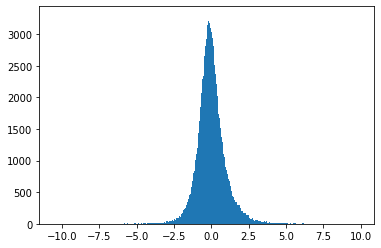

In [111]:
# draw histogram for one feature
import matplotlib.pyplot as plt
feature = 'return_20_days'
plt.hist(data[feature], bins = 1000)
# compute mean, std, skewness, kurtosis
print('mean: ', round(data[feature].mean(), 4))
print('std: ', round(data[feature].std(), 4))
print('skewness: ', round(data[feature].skew(), 4))
print('kurtosis: ', round(data[feature].kurt(), 4))
# set x-axis range
plt.show()

提取训练需要的数据并标准化

In [112]:
# 分割训练集与测试集
train = data[data.index.get_level_values('date') < '2021-01-01']
test = data[data.index.get_level_values('date') >= '2021-01-01']
train.head()

,,bias5,bias10,bias20,vol5,vol10,vol20,return_5_days,return_10_days,return_20_days,label_short
date,stock,,,,,,,,,,
2017-02-07,000582.SZ,-0.028101,-0.100088,-0.206577,-0.507541,-0.627593,-0.313752,-0.251206,0.007549,-0.041379,True
2017-02-08,000582.SZ,4.143629,3.153257,2.143105,1.650957,0.480493,-0.217329,2.516664,1.828255,1.055927,False
2017-02-09,000582.SZ,3.762504,3.177037,2.300920,2.561275,1.077366,-0.058701,2.751373,2.046100,1.204754,False
2017-02-10,000582.SZ,2.493203,2.932913,2.291664,3.284062,1.444416,0.067135,2.883403,2.312849,1.006813,False
2017-02-13,000582.SZ,0.822957,1.875852,1.815449,2.007872,1.490124,0.218970,2.697108,1.958899,0.976559,True


In [113]:
# 生成训练集和测试集的特征和标签
train_x = train.drop(['label_short'], axis = 1)
train_y_short = train['label_short']
test_x = test.drop(['label_short'], axis = 1)
test_y_short = test['label_short']

## 模型训练

In [115]:
# 导入SVM模型
from sklearn import svm
# 建立模型
model_short = svm.SVC()
# 训练模型
model_short.fit(train_x, train_y_short)
# 预测300571.SZ的涨跌
pred_short = model_short.predict(test_x)
# 评估
from sklearn.metrics import accuracy_score
print('The accuracy of signal out of sample is ' + str(accuracy_score(test_y_short, pred_short) * 100) + '%.')

The accuracy of short signal out of sample is 65.92131280838245%.


## 看看

选出几只股票可视化一下卖点

In [116]:
stock = constituents[3]
test_x_stock = test_x.loc[test_x.index.get_level_values('stock') == stock]
test_y_stock = test_y_short.loc[test_y_short.index.get_level_values('stock') == stock]
pred_y_stock = pred_short[test_y_short.index.get_level_values('stock') == stock]
print('The accuracy of short signal in the test set for ' + stock + ' is ' + str(round(accuracy_score(test_y_stock, pred_y_stock) * 100, 2)) + '%.')

The accuracy of short signal in the test set for 300352.SZ is 76.8%.


In [117]:
correct = test_y_stock & pred_y_stock
wrong = pred_y_stock & ~test_y_stock
print('Correctly predicted ' + str(correct.sum()) + ' days')
print('Wrongly predicted ' + str(wrong.sum()) + ' days')

Correctly predicted 427 days
Wrongly predicted 129 days


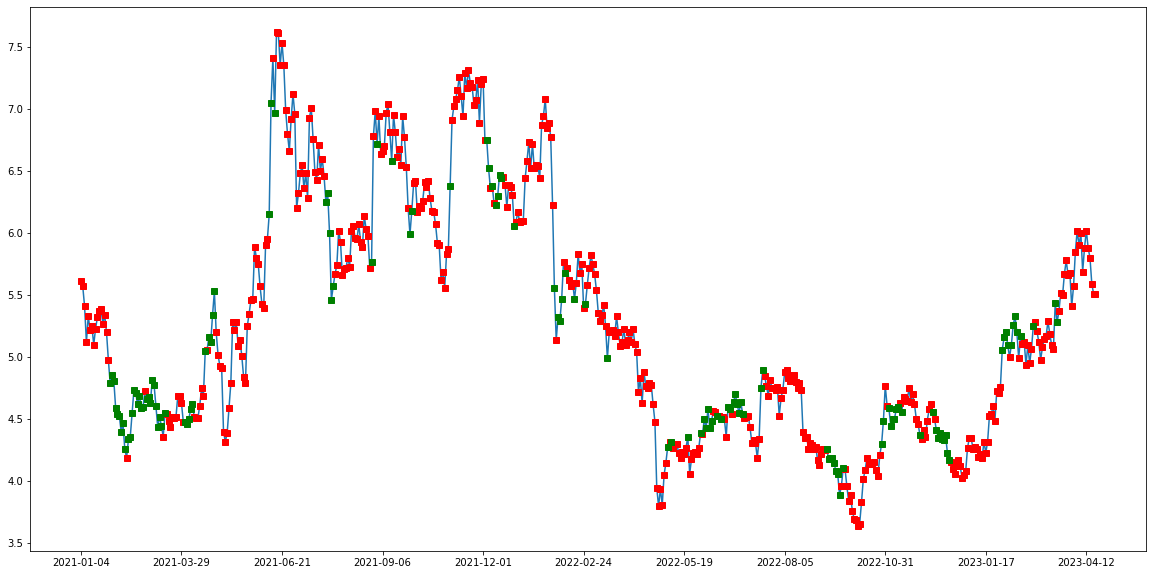

In [118]:
# 根据data中的数据，画出股票k线图
import matplotlib.pyplot as plt
import numpy as np
plot_index = test_y_stock.index
plt.figure(figsize = (20, 10))
plt.plot(plot_index.get_level_values('date'), raw_data.loc[plot_index].close)
# 标记正确买入点
plt.plot(plot_index[correct].get_level_values('date'), raw_data.loc[plot_index].close[correct], 'rs')
# 标记错误买入点
plt.plot(plot_index[wrong].get_level_values('date'), raw_data.loc[plot_index].close[wrong], 'gs')
my_x_ticks = np.arange(0, len(test_x_stock.index), int(len(test_x_stock.index) / 10))
plt.xticks(my_x_ticks)
plt.show()

红色为正确预测，绿色为错误预测